# Задание 2

### 1. Одномерная линейная регрессия.
Вывести формулу линейной регрессии для одномерного случая. Дана
выборка $\{x_i,y_i\}_{i=1}^N$, минимизируя среднеквадратичную ошибку определить
коэффициенты линейной регрессии: $a(x)=w_0+w_1x$.

### 2. Оптимальный шаг градиентного спуска. 
Рассмотрим задачу обучения линейной регрессии:

$$
Q(\vec{w})=(X\vec{w}-\vec{y})^T(X\vec{w}-\vec{y}) \to \min_{w},
$$
и будем решать ее с помощью градиентного спуска. Допустим, мы находимся на некоторой итерации $k$, и хотим выполнить очередной шаг:
$$
\vec{w}^{(k)}=\vec{w}^{(k-1)}-\eta \nabla_w Q(\vec{w}^{(k-1)}).
$$
При известных $ \vec{y}, X,\vec{w}^{(k-1)}$, определите длину шага $\eta$, при которой уменьшение значение функционала будет наибольшим, т.е.: 

$$
Q(\vec{w}^{(k-1)}-\eta \nabla_w Q(\vec{w}^{(k-1)})) \to \min_{\eta}.
$$

In [54]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import GridSearchCV


### 3. Стохастический градиентный спуск 
Напишите функцию стохастического градиентного спуска. 
Функция использует для оценки градиента всего функционала ошибки значение градиента, вычисленного по подвыборке размера batch_size=10. Визуализируйте траекторию, длина шага $\eta=1$.

In [55]:
np.random.seed(17)
n_features = 2
n_objects = 300
w_true = np.array([1.0,1.0])
X = np.random.uniform(-5,5, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0,1, (n_objects))

In [56]:
def stochastic_grad_descent_step(X, y, w, random_ind, step_size):
    
    w =w- 2 * step_size * np.dot(X[random_ind].T, np.dot(X[random_ind], w) - y[random_ind])/X.shape[0]

    return w

In [57]:
def stochastic_grad_descent(X, y, w_0,step_size, num_steps, batch_size):
    w = w_0
    iter_num = 0
    w_list=[]
    
    while iter_num < num_steps:
        
        w_list.append(w)
        random_ind = np.random.randint(0,len(X),size=batch_size)
        new_w = stochastic_grad_descent_step(X, y, w, random_ind, step_size)
        w = new_w
        iter_num += 1  
        
    return w_list

In [58]:
num_steps = 20
step_size = 1
batch_size = 10
w_0 = np.array([0,0])
w_list=stochastic_grad_descent(X, Y, w_0,step_size, num_steps, batch_size)
w_list = np.array(w_list)
w_list

array([[0.        , 0.        ],
       [0.08797425, 0.73171037],
       [0.27853064, 0.94737474],
       [0.76567689, 1.1251351 ],
       [0.98983636, 1.05431178],
       [0.96494101, 0.92079528],
       [1.09130561, 0.92859539],
       [1.03378279, 1.08148335],
       [1.06012568, 1.13469987],
       [1.03073724, 1.15863317],
       [1.01019301, 1.12851874],
       [0.98259954, 1.02240395],
       [0.9820263 , 0.97662236],
       [1.03879191, 0.91720733],
       [0.98237923, 0.78657226],
       [1.08414831, 0.92953982],
       [1.15562445, 0.89124664],
       [1.01133001, 0.9916654 ],
       [1.09798807, 1.09326849],
       [0.92322868, 1.04901934]])

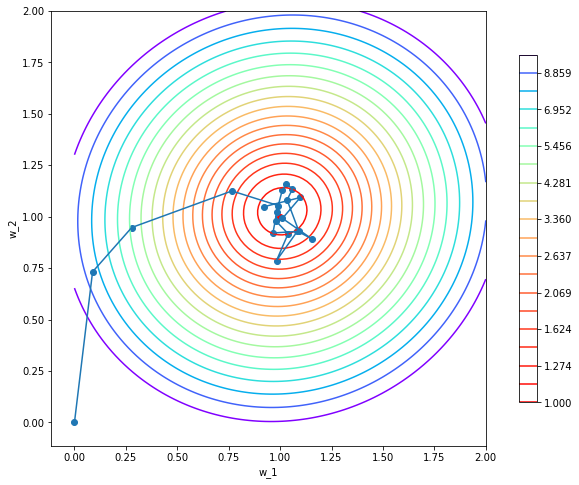

In [59]:
A, B = np.meshgrid(np.linspace(0, 2, 100), np.linspace(0, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(12, 8))
plt.xlabel('w_1')
plt.ylabel('w_2')
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(w_list[:, 0], w_list[:, 1])
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

### 4. Линейная регрессия на данных. Оценка важности признаков.  

In [60]:
from sklearn.datasets import load_boston
data = load_boston()
feature_names = data.feature_names
print(feature_names)
X = data.data
y = data.target
N, d = X.shape
print( N, d)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
506 13


#### 4.1 Напишите функцию, которая вычисляет ошибку RMSE (root mean square error):
$$ RMSE(a,\mathbb X)=\sqrt{\frac{\sum_{i=1}^{N}(a(x_i)-y_i)^2}{N}}.$$


In [61]:
from sklearn.metrics import mean_squared_error 
def rmse (y_pred , y):
    return np.sqrt(mean_squared_error(y_pred, y))

Разбейте выборку на обучающую и тестовую в соотношении 7:3. Проведите стандартизацию признаков, постройте линейную регресcию и ответьте на следующие вопросы. 
#### 4.2. Какова ошибка RMSE  линейной регрессии на обучающей  выборке?

#### 4.3. Какова ошибка RMSE линейной регрессии на тестовой выборке?

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

print('RMSE train sample =', rmse(lr.predict(X_train), y_train))
print('RMSE test sample =', rmse(lr.predict(X_test), y_test))



RMSE train sample = 4.748208239685937
RMSE test sample = 4.638689926172819


####  4.4. Распределение ошибок на обучающей выборке. 
Посчитайте отклонение на каждом обучающем объекте: 
$$\delta^{j}_{train}=y_{pred}^{j}-y_{train}^{j},$$
и постройте распределение этих отклонений. Какой статистике подчиняется полученное распределение?

Text(0.5, 1.0, 'Delta distribution')

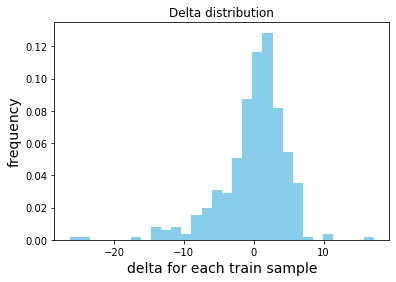

In [72]:
def delta (y_pred, y):
           return (y_pred - y)

delta_list=delta(lr.predict(X_train), y_train)

plt.hist(delta_list,bins=30,density=True, color='skyblue')
plt.xlabel('delta for each train sample',fontsize=14)
plt.ylabel('frequency',fontsize=14)
plt.title('Delta distribution')

# Получили нормальное распредление 



#### 4.5. Постройте диаграмму важности признаков. 
Используйте plt.bar, отсортируйте признаки по важности (модуль соответствующего коэффициента в линейной регрессии) и постройте диаграмму.  Какой признак наиболее важный?

Text(0.5, 1.0, 'Weights of features')

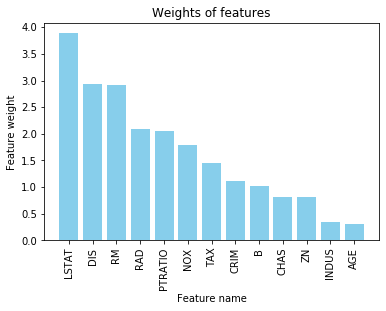

In [64]:
w = abs(lr.coef_)
w = pd.DataFrame({'Feature name':feature_names,'Feature weight':w},columns = ['Feature name','Feature weight'])
w1= w.sort_values(by='Feature weight',ascending=False)
w1

plt.bar(w1['Feature name'],w1['Feature weight'],color='skyblue')
plt.xticks(range(len(w1['Feature weight'])), w1['Feature name'], rotation=90)
plt.xlabel('Feature name')
plt.ylabel('Feature weight')
plt.title('Weights of features')

#Наиболее важный признак - LSTAT

### 5. Отбор признаков в Lasso регрессии. 
Рассмотрим Lasso регрессию с различным параметром регуляризации $\alpha \in [10^{-3},10^3]$. Посмотрите, какое количество коэффициентов зануляется в линейной модели. Воспользуйтесь кроссвалидацией (например, ShuffleSplit), чтобы построить несколько алгоритмов для одного и того же значения  $\alpha$, а затем взять среднее число ненулевых коэффициентов по этим алгоритмам.  Постройте график зависимости (логарифмический масштаб по оси абсцис) среднего числа ненулевых коэффициентов от коэффицента регуляризации $\alpha$.

P.S. Обратите внимание на необходимость стандартизации при каждом разбиении выборки.  

In [65]:
alphas = np.logspace(-3, 3,20)

for i in range(len(alphas)):
    lasso_model = Lasso(alphas[i])
    lasso_model.fit(X_train, y_train)
    w['lasso_coef ', alphas[i]]=lasso_model.coef_
w



,Feature name,Feature weight,"(lasso_coef , 0.001)","(lasso_coef , 0.00206913808111479)","(lasso_coef , 0.004281332398719396)","(lasso_coef , 0.008858667904100823)","(lasso_coef , 0.018329807108324356)","(lasso_coef , 0.0379269019073225)","(lasso_coef , 0.07847599703514611)","(lasso_coef , 0.1623776739188721)",...,"(lasso_coef , 1.438449888287663)","(lasso_coef , 2.976351441631316)","(lasso_coef , 6.158482110660261)","(lasso_coef , 12.742749857031322)","(lasso_coef , 26.366508987303554)","(lasso_coef , 54.555947811685144)","(lasso_coef , 112.88378916846884)","(lasso_coef , 233.57214690901213)","(lasso_coef , 483.2930238571752)","(lasso_coef , 1000.0)"
0,CRIM,1.108346,-1.105284,-1.101997,-1.095230,-1.081204,-1.052316,-0.993683,-0.869584,-0.616646,...,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,ZN,0.808440,0.803429,0.798091,0.787029,0.764068,0.716495,0.621142,0.466541,0.239927,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,INDUS,0.343135,0.333525,0.323243,0.302120,0.258534,0.168615,0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,CHAS,0.813864,0.814330,0.814824,0.815837,0.817937,0.822275,0.830026,0.826441,0.799710,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NOX,1.798043,-1.791051,-1.783486,-1.767933,-1.735779,-1.669747,-1.540375,-1.375382,-0.918348,...,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
5,RM,2.913858,2.914151,2.914443,2.915073,2.916439,2.919356,2.926486,2.975852,3.033271,...,2.505283,1.750375,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,AGE,0.298939,-0.297064,-0.295027,-0.290851,-0.282282,-0.264704,-0.228357,-0.161074,-0.012547,...,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
7,DIS,2.942511,-2.935509,-2.927988,-2.912408,-2.880094,-2.813357,-2.674190,-2.331757,-1.679466,...,-0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,RAD,2.094193,2.075897,2.056315,2.016018,1.932577,1.760471,1.416038,0.830101,0.118741,...,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
9,TAX,1.447067,-1.429136,-1.409989,-1.370554,-1.288927,-1.120318,-0.785723,-0.311315,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [66]:
coef=[]
sum=0
sum_notnull=[]

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=23)
for i in range(len(alphas)):
    for train, test in cv.split(X):
        scaler.fit(X[train])
        X[train] = scaler.transform(X[train])
        X[test] = scaler.transform(X[test])
        lasso_model = Lasso(alphas[i])
        lasso_model.fit(X[train], y[train])
        coef=lasso_model.coef_
        for j in range(len(coef)):
            if (coef[j] != 0):
                sum+=1
    sum_notnull.append(sum/5)
    sum=0
al= pd.DataFrame({'alphas': alphas,'average sum of notnull features': sum_notnull},
                 columns = ['alphas','average sum of notnull features'])
al


,alphas,average sum of notnull features
0,0.001000,12.8
1,0.002069,12.8
2,0.004281,12.8
3,0.008859,12.6
4,0.018330,12.4
5,0.037927,12.2
6,0.078476,11.8
7,0.162378,11.2
8,0.335982,9.0
9,0.695193,5.8


Text(0.5, 1.0, 'dependence of the number of non-zero features from the value of alpha')

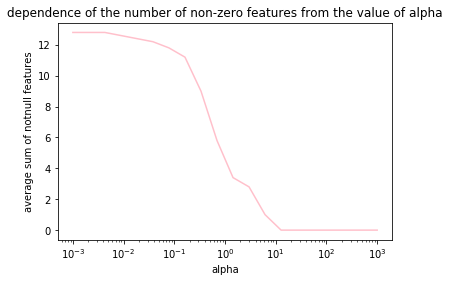

In [67]:
plt.plot(alphas, al["average sum of notnull features"], color = 'pink')
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("average sum of notnull features")
plt.title('dependence of the number of non-zero features from the value of alpha')

### 6. Подбор параметров. 
#### 6.1. С помощью GridSearch определите параметры регуляризации для Ridge и Лассо моделей. 

In [68]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], cv=10)
searcher.fit(X_train, y_train)
alpha_Ridge=searcher.best_params_
print('alpha for Ridge model = ', alpha_Ridge['alpha']);

alpha for Ridge model =  14.38449888287663


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [69]:
searcher = GridSearchCV(Lasso(), [{"alpha": alphas}], cv=10)
searcher.fit(X_train, y_train)
alpha_Lasso=searcher.best_params_
print('alpha for Lasso model = ', alpha_Lasso['alpha']);

alpha for Lasso model =  0.03359818286283781


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### 6.2. Постройте модели с найденными наилучшими параметрами регуляризации на обучающей выборке из пункта 4. Какова ошибка RMSE на обучающей выборке и тестовой?

In [70]:
ridge_model = Ridge(alpha = alpha_Ridge['alpha'])
ridge_model.fit(X_train, y_train)
print('RMSE for Ridge model on train sample =', rmse(ridge_model.predict(X_train), y_train))
print('RMSE for Ridge model on test sample =', rmse(ridge_model.predict(X_test), y_test))

RMSE for Ridge model on train sample = 4.766720340654435
RMSE for Ridge model on test sample = 4.682339444606876


In [71]:
lasso_model = Lasso(alpha = alpha_Lasso['alpha'])
lasso_model.fit(X_train, y_train)
print('RMSE for Lasso model on train sample =', rmse(lasso_model.predict(X_train), y_train))
print('RMSE for Lasso model on test sample =', rmse(lasso_model.predict(X_test), y_test))

RMSE for Lasso model on train sample = 4.756743714054295
RMSE for Lasso model on test sample = 4.664345956205484
